In [16]:
# Data import
import pandas as pd

df=pd.read_csv("BankChurners.csv",skipinitialspace=True)

df.drop(["CLIENTNUM","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1","Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"],axis=1,inplace=True)

# Select numerical features for clustering
#X = df[["Total_Trans_Ct","Total_Trans_Amt"]]
X = df[["Total_Trans_Ct","Total_Trans_Amt", "Total_Revolving_Bal", "Total_Amt_Chng_Q4_Q1", "Total_Ct_Chng_Q4_Q1"]]
#X = df[["Total_Trans_Ct","Total_Trans_Amt", "Total_Revolving_Bal", "Total_Amt_Chng_Q4_Q1", "Total_Ct_Chng_Q4_Q1", "Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Customer_Age", "Credit_Limit", "Months_on_book"]]

X

,Total_Trans_Ct,Total_Trans_Amt,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1
0,42,1144,777,1.335,1.625
1,33,1291,864,1.541,3.714
2,20,1887,0,2.594,2.333
3,20,1171,2517,1.405,2.333
4,28,816,0,2.175,2.500
...,...,...,...,...,...
10122,117,15476,1851,0.703,0.857
10123,69,8764,2186,0.804,0.683
10124,60,10291,0,0.819,0.818
10125,62,8395,0,0.535,0.722


In [17]:
# Computing feature importance
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Standardize the data using the StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize KMeans algorithm and fit to data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Calculate the within-cluster sum of squares (WCSS) for each feature
wcss = np.sum(kmeans.inertia_ * np.square(X_scaled - kmeans.cluster_centers_[kmeans.labels_]), axis=0)

# Sort the features by their WCSS scores in descending order
features_ranked = np.argsort(wcss)[::-1]

# Print the ranked features
print("Ranked features by importance:")
for feature in features_ranked:
    print("Feature %d: %.4f" % (feature, wcss[feature]))


Ranked features by importance:
Feature 3: 143879412.0601
Feature 4: 136004790.3423
Feature 2: 118381200.3430
Feature 0: 59512276.2218
Feature 1: 34277707.6257


Top features for PCA component 1: [(0.672874522551408, 'Total_Trans_Ct'), (0.6728085141794035, 'Total_Trans_Amt'), (0.23559139677244617, 'Total_Ct_Chng_Q4_Q1')]
Top features for PCA component 2: [(0.6784057495683151, 'Total_Amt_Chng_Q4_Q1'), (0.6443794859585438, 'Total_Ct_Chng_Q4_Q1'), (0.1967918402435225, 'Total_Revolving_Bal')]


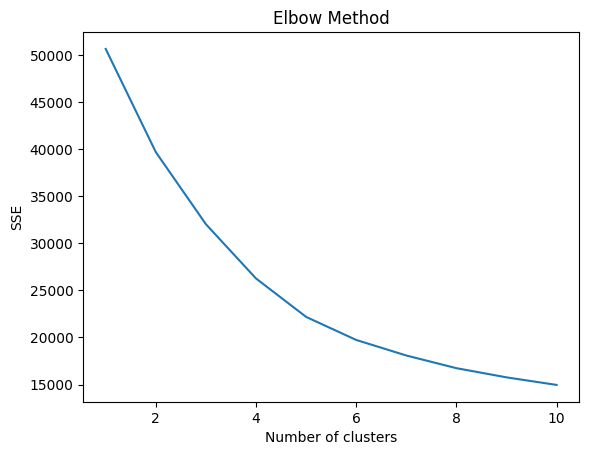

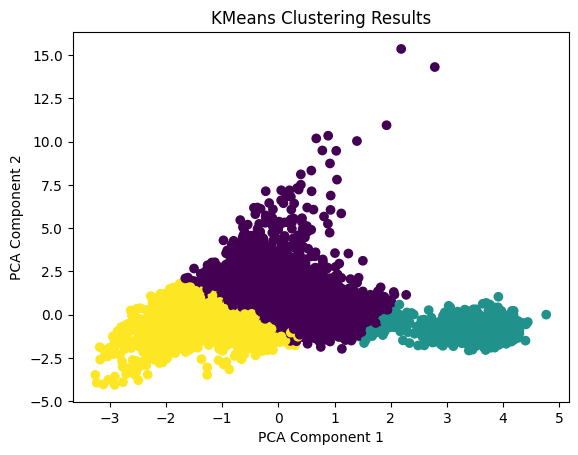

0    5999
2    3285
1     843
Name: KMeans_Cluster, dtype: int64


In [18]:
# Clustering with KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Standardize features to have mean=0 and variance=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Reduce dimensionality to two dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Get feature loadings for each principal component
loadings = pca.components_

# Get feature names from the original dataset
feature_names = X.columns.tolist()

# Print top 3 features for each principal component
for i, pc in enumerate(loadings):
    top_features = sorted(zip(pc, feature_names), reverse=True)[:3]
    print(f"Top features for PCA component {i+1}: {top_features}")

# Perform clustering with K-Means algorithm for different number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    sse.append(kmeans.inertia_)

# Plot SSE for different number of clusters
plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Choose optimal number of clusters based on elbow point
k = 3

# Perform clustering with optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_std)

# Add cluster labels to original data
df["KMeans_Cluster"] = kmeans.labels_

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Results')
plt.show()

# Print number of customers in each cluster
print(df["KMeans_Cluster"].value_counts())

# Save df with cluster back to CSV
df.to_csv(".\Clustering_Results\BankChurners_w_Clustering_output_KMeans.csv", index=False)
